In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

np.set_printoptions(precision=5, linewidth=999, suppress=True)

In [2]:
def kernel(x, y, sigma=1.0):
    return np.exp(-0.5 * np.subtract.outer(x, y)**2 / sigma**2)

def kernel_diag(x, sigma=1.0):
    return np.exp(-0.5 * np.subtract(x, x)**2 / sigma**2)

## Nystrom GPR

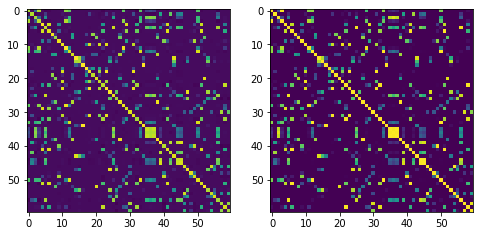

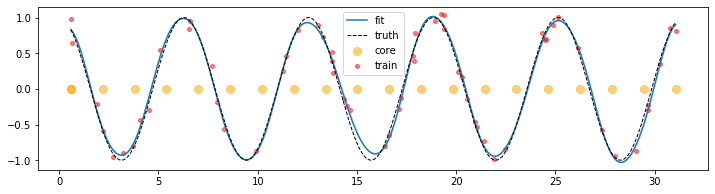

Kxx_nystrom_1 by brute force (Kxc * Kcc^-1 * Kcx)
[[ 0.86771  0.00656  0.32724 ... -0.00027 -0.00087 -0.00022]
 [ 0.00656  0.8791  -0.02397 ...  0.       0.00058  0.     ]
 [ 0.32724 -0.02397  0.85399 ...  0.00007  0.01082  0.00006]
 ...
 [-0.00027  0.       0.00007 ...  0.86241 -0.00153  0.82405]
 [-0.00087  0.00058  0.01082 ... -0.00153  0.93392 -0.00124]
 [-0.00022  0.       0.00006 ...  0.82405 -0.00124  0.85827]]
Kxx_nystrom_2 by SVD of Kxc
[[ 0.86771  0.00656  0.32724 ... -0.00027 -0.00087 -0.00022]
 [ 0.00656  0.8791  -0.02397 ...  0.       0.00058  0.     ]
 [ 0.32724 -0.02397  0.85399 ...  0.00007  0.01082  0.00006]
 ...
 [-0.00027  0.       0.00007 ...  0.86241 -0.00153  0.82405]
 [-0.00087  0.00058  0.01082 ... -0.00153  0.93392 -0.00124]
 [-0.00022  0.       0.00006 ...  0.82405 -0.00124  0.85827]]
inverse of Kxx_nystrom by brute force (spectral pseudoinverse)
[[ 0.0488  -0.01609 -0.01941 ... -0.00606 -0.04928 -0.00166]
 [-0.01609  1.07018  0.05913 ... -0.00226 -0.03223 -0.

In [3]:
np.random.seed(0)
N = 60
e = 0.1  # artificial noise
X = np.random.rand(N) * 10 * np.pi
f = lambda x: np.cos(x)
y = f(X) + np.random.randn(N) * e

C = np.linspace(X.min(), X.max(), 20)  # the core set that defines the subspace for Nystrom projection
C = np.concatenate([C, C[:1]])
Y = np.linspace(X.min(), X.max(), 300)

Kcc = kernel(C, C)
Wcc, Ucc = np.linalg.eigh(Kcc)
mask = Wcc > 0  # !!!
Wcc = Wcc[mask]  # !!!
Ucc = Ucc[:, mask]  # !!!
Kccinv = (Ucc / Wcc).dot(Ucc.T)

Kxc = kernel(X, C)
# use Uxx, Sxx to represent Kxx^-1 without storing either Kxx_nystrom or its inverse explicitly
Uxx, Sxx, _ = np.linalg.svd(Kxc.dot((Ucc / Wcc**0.5).dot(Ucc.T)), full_matrices=False)
mask = Sxx > 1e-10  # !!!
Uxx = Uxx[:, mask]  # !!!
Sxx = Sxx[mask]  # !!!

Kxx_ihalf = Uxx / Sxx

Kyc = kernel(Y, C)
Kyx_nystrom = Kyc.dot(Kccinv).dot(Kxc.T)
Kyy_nystrom = np.einsum("ij,jk,ki->i", Kyc, Kccinv, Kyc.T)
Kyxx_half = Kyx_nystrom.dot(Kxx_ihalf)

z = Kyx_nystrom.dot(Kxx_ihalf).dot((Kxx_ihalf.T).dot(y))
v = Kyy_nystrom - np.einsum('ij,ji->i', Kyxx_half, Kyxx_half.T)
u = np.sqrt(np.maximum(v, 0))

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow((Uxx * Sxx**2).dot(Uxx.T))
axs[1].imshow(kernel(X, X))
plt.show()

plt.figure(figsize=(12, 3))
plt.scatter(C, np.zeros_like(C), s=64, color='orange', alpha=0.5, label='core')
plt.scatter(X, y, s=16, color='r', alpha=0.5, label='train')
plt.plot(Y, z, label='fit')
plt.plot(Y, f(Y), ls='dashed', lw=1.0, color='k', zorder=10, label='truth')
plt.fill_between(Y, z - 1.96 * u, z + 1.96 * u, alpha=0.1, color='k')
plt.legend()
plt.show()

Kxx_nystrom_1 = (Kxc.dot(Ucc) / Wcc).dot(Ucc.T).dot(Kxc.T)
print('Kxx_nystrom_1 by brute force (Kxc * Kcc^-1 * Kcx)\n', Kxx_nystrom_1, sep='')
Kxx_nystrom_2 = (Uxx * Sxx**2).dot(Uxx.T)
print('Kxx_nystrom_2 by SVD of Kxc\n', Kxx_nystrom_2, sep='')
print('====================================================')
print('inverse of Kxx_nystrom by brute force (spectral pseudoinverse)\n', np.linalg.pinv(Kxx_nystrom_1), sep='')
print('inverse of Kxx_nystrom by SVD\n', (Uxx / Sxx**2).dot(Uxx.T), sep='')
print('====================================================')
print('z by brute force inverse\n', Kyx_nystrom.dot(np.linalg.pinv(Kxx_nystrom_1).dot(y)))
print('z by SVD inverse\n', z, sep='')
